<a href="https://colab.research.google.com/github/zeynepdicle/tflite_simple_audio/blob/main/evetSpeechRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install tensorflow==2.4.0

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=a30b800b5794e73e7616064f70141d033b756a01a89334e01eec80b304a9f318
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display


# Set seed for experiment reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/demo/mini_speech_commands')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['evet']


In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 1885
Number of examples per label: 1885
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/demo/mini_speech_commands/evet/evet_WQVC_JGMFCHE.wav', shape=(), dtype=string)


In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 1885
Validation set size 0
Test set size 800


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

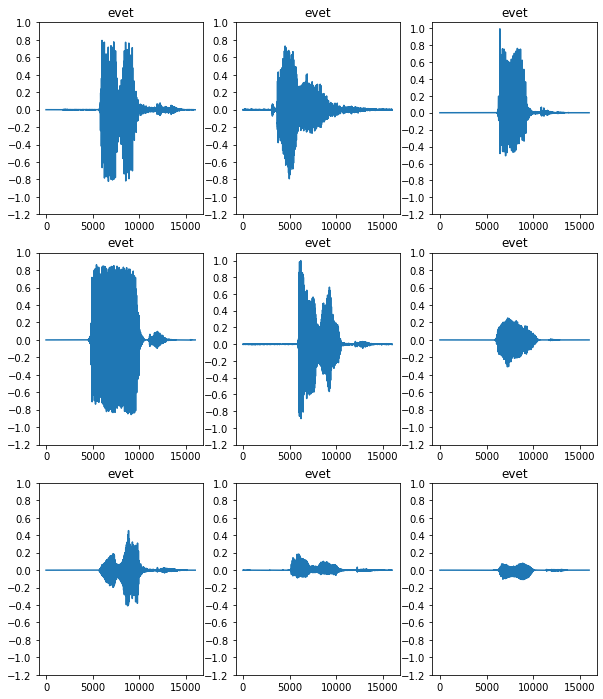

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: evet
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Audio playback


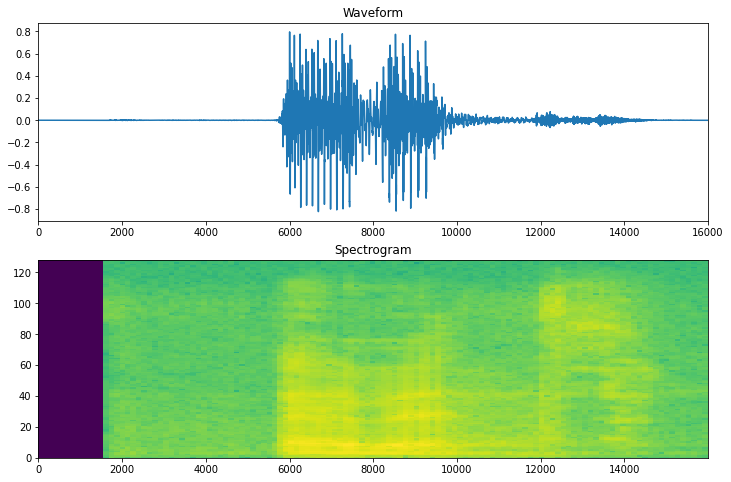

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns). An epsilon is added to avoid log of zero.
  log_spec = np.log(spectrogram.T+np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

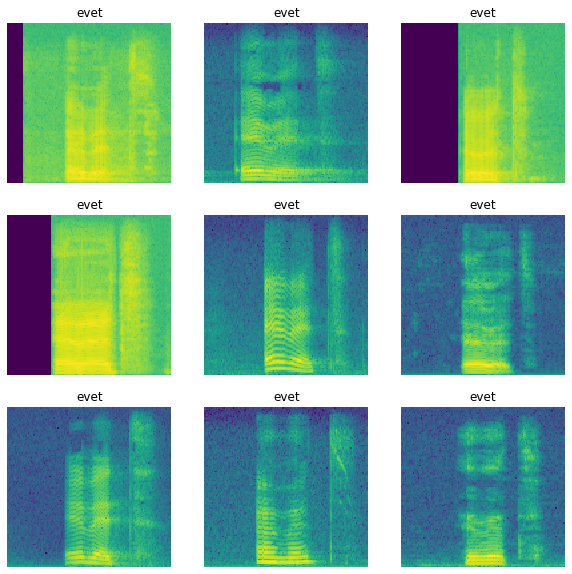

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
30/30 [==============================] - 39s 212ms/step - loss: 0.0000e+00 - accuracy: 0.9432
Epoch 2/10
30/30 [==============================] - 1s 18ms/step - loss: 0.0000e+00 - accuracy: 0.9575
Epoch 3/10
30/30 [==============================] - 1s 17ms/step - loss: 0.0000e+00 - accuracy: 0.9596
Epoch 4/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.9471
Epoch 5/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.9524
Epoch 6/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.9412
Epoch 7/10
30/30 [==============================] - 0s 15ms/step - loss: 0.0000e+00 - accuracy: 0.9436
Epoch 8/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.9397
Epoch 9/10
30/30 [==============================] - 0s 16ms/step - loss: 0.0000e+00 - accuracy: 0.9418
Epoch 10/10
30/30 [==============================] - 0s 16ms/step - los

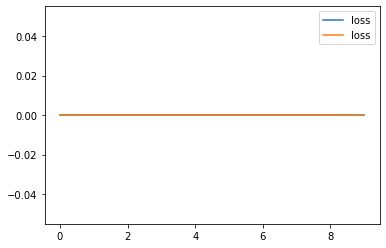

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['loss'])
plt.legend(['loss', 'loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 100%


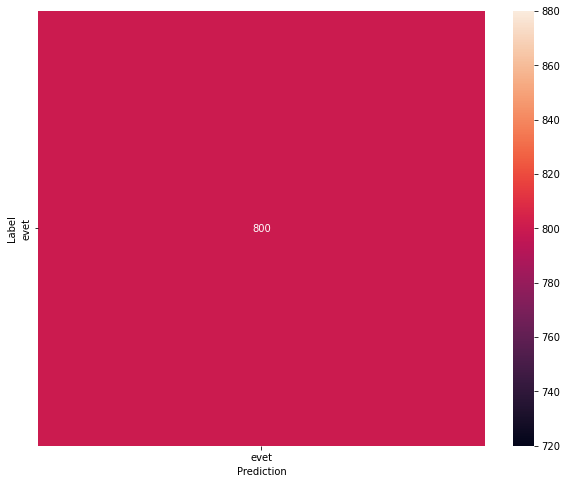

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

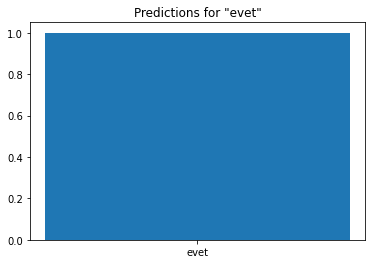

In [ ]:
sample_file = data_dir/'evet/evet_IUBA_TLICGFY.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

In [ ]:
#generate a saved model in TF format
export_dir = 'saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1/assets


In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
model_no_quant_tflite = converter.convert()

# Save the model to disk
open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8


In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file, i.e, a TensorFlow Lite for Microcontrollers model
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:10 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [67.4 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packa

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
};
unsigned int g_model_len = 0;
